Задача - исследовать поведение клиентов и предсказать совершенение клиентом покупки.

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('HW_CBR.csv')

In [4]:
df.head()

,pdp_view,add_favorite,del_favorite,add_cart,del_cart,avail_on,pre_order,orders,target,ClientId
0,15,1,0,4,0,1,1,9,1,0
1,0,0,0,0,0,0,0,0,0,1
2,3,0,0,1,0,0,0,4,1,2
3,24,0,0,6,0,0,0,3,1,3
4,0,0,0,0,0,0,0,6,1,4


In [5]:
df.shape

(2611231, 10)

In [6]:
df['ClientId'].unique().shape

(2611231,)

In [7]:
train_size = int(0.5 * df.shape[0])
test_size = int(0.75 * df.shape[0])
train = df.iloc[:train_size]
test = df.iloc[train_size:test_size]
val = df.iloc[test_size:]

In [8]:
features = ['pdp_view','add_favorite','del_favorite', 'add_cart', 'del_cart', 'avail_on', 'pre_order', 'orders']
target = ['target']

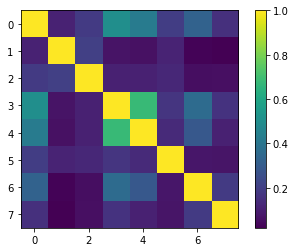

In [9]:
plt.imshow(train[features].corr(), interpolation='none') 
plt.colorbar()

In [10]:
import seaborn as sns

sns.set()

In [11]:
import math

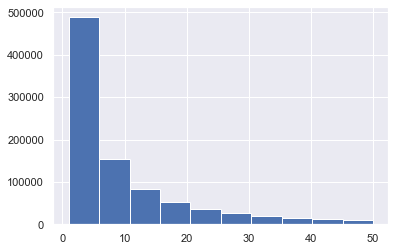

In [12]:
train['pdp_view'].hist(bins=10,range=(1, 50))

plt.show()

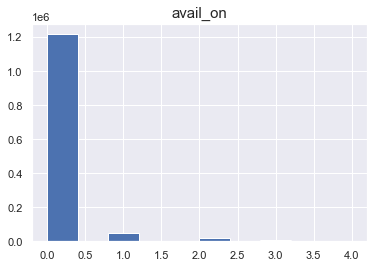

In [13]:
train['avail_on'].hist(bins=10,range=(0, 4))
plt.title('avail_on',fontsize=15)
plt.savefig('avail_on.jpg')
plt.show()

Оказывается, мало людей подписывается на товары, которых нет в наличии. Возможно, это связано с тем, что таких товаров мало.  На диаграмме показано распределение количества подписок среди 1305615 пользователей (train). Всего 88445 пользователей подписались и среди них 71523 сделали заказы.

In [14]:
train.shape[0] - train[train['avail_on'] == 0].shape[0]

88445

In [15]:
train[train['avail_on'] != 0].loc[train['target'] == 1].shape[0]

71523

In [16]:
order = train.loc[train['target'] == 1, 'ClientId']
not_order = train.loc[train['target'] == 0, 'ClientId']

In [17]:
order.shape[0] / (order.shape[0] + not_order.shape[0])

0.7159775278317115

In [18]:
not_order.shape[0] / (order.shape[0] + not_order.shape[0])

0.2840224721682885

In [19]:
not_order.shape[0]

370824

In [20]:
train.shape

(1305615, 10)

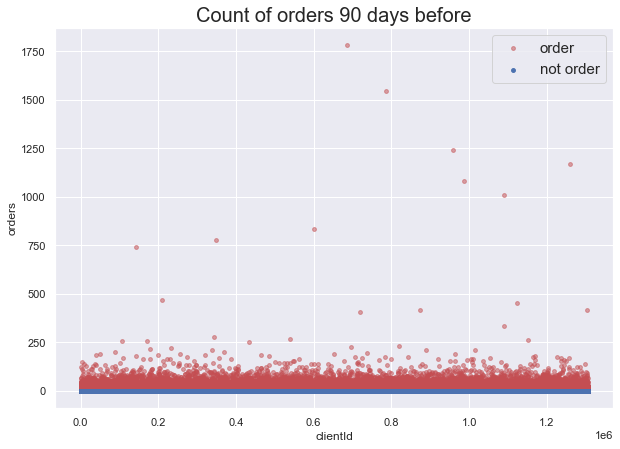

In [21]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(7)
plt.scatter(order, train.loc[train['target'] == 1, 'orders'], s=15, c='r', alpha = 0.5, label='order')
plt.scatter(not_order, train.loc[train['target']== 0, 'orders'], s=15, c='b', label='not order')
plt.title('Count of orders 90 days before',fontsize=20)
plt.xlabel('clientId')
plt.ylabel('orders')
plt.legend(fontsize=15)
plt.savefig('90days.jpg')

Из данных для train выяснилось, что клиенты, которые не делали заказ в течение 3-х дней с момента сессии, не совершали заказ и за 90 дней до. На графике голубым цветом помечены клиенты, не сделавшие заказ. Клиенты, которые сделали заказ в течение 3-х дней (помечены красным), как заказывали, так и не заказывали за 90 дней.

In [23]:
pre_order = train[train['pdp_view'] == 0].loc[train['target'] == 1, train.columns[[1, 3, 6, 7]]]

In [24]:
pre_order.head()

,add_favorite,add_cart,pre_order,orders
4,0,0,0,6
10,0,1,0,3
11,0,0,0,1
15,0,0,0,4
18,0,0,0,12


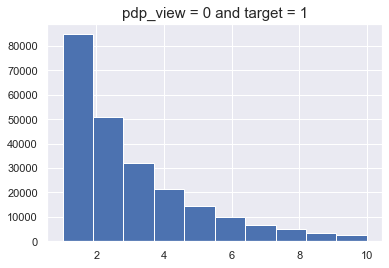

In [25]:
fig, ax = plt.subplots()
pre_order['orders'].hist(bins=10,range=(1, 10))
plt.title('pdp_view = 0 and target = 1',fontsize=15)
plt.savefig('pdp_view_0.jpg')
plt.show()

Все клиенты из выборки train, которые не просматривали страницы на сайте в сессию и сделали заказ, делали заказы за 90 дней до. На диаграмме показано распределение этих заказов среди пользователей с критерием pdp_view=0 и target =1.

In [26]:
pre_order[pre_order['orders']== 0].shape

(0, 4)

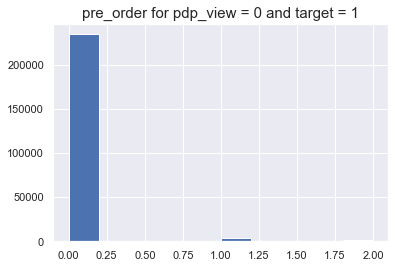

In [27]:
pre_order['pre_order'].hist(bins=10,range=(0, 2))
plt.title('pre_order for pdp_view = 0 and target = 1',fontsize=15)
plt.savefig('pdp_view_0_tar_1_pre_order.jpg')
plt.show()

Также пользователи не посещали страницы с выбором доставки и типа оплаты (pre_order = 0). Ниже изображена диаграмма распределения pre_order  для данных пользователей.

In [28]:
pre_order_not = train[train['pdp_view'] == 0].loc[train['target'] == 0, train.columns[[1, 3, 6, 7]]] 

In [29]:
pre_order_not.shape

(115103, 4)

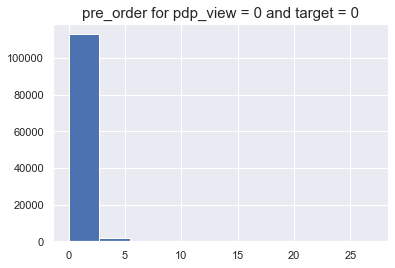

In [30]:
pre_order_not['pre_order'].hist(bins=10)
plt.title('pre_order for pdp_view = 0 and target = 0',fontsize=15)
plt.savefig('pdp_view_0_tar_0_pre_order.jpg')
plt.show()

In [35]:
view = train[train['pdp_view'] != 0].loc[train['target'] == 0, train.columns]

In [36]:
view.shape

(255721, 10)

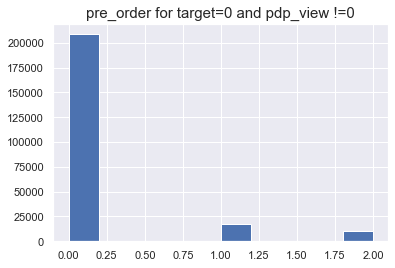

In [37]:
view['pre_order'].hist(bins=10,range=(0, 2))
plt.title('pre_order for target=0 and pdp_view !=0', fontsize=15)
plt.savefig('pdp_view_1_tar0.jpg')
plt.show()

Из данных для train (1305615) следует, что количество тех, кто не делает заказ, меньше: 0.284 (370824), то есть классы не сбалансированы. Значит, больше интересны те пользователи, которые не делают заказы, их сложнее предсказать. При pdp_view ! =0 большинство из них не посещает страницы с выбором доставки и типа оплаты, то есть pre_order = 0. На графике это показано.

In [38]:
pred_features = ['pdp_view', 'avail_on', 'pre_order', 'orders']

In [39]:
clf = LGBMClassifier(n_estimators=50,learning_rate=0.05,num_leaves=63,max_depth=5)
clf.fit(
    train[pred_features], train[target].values.ravel(),
    eval_set=[(test[pred_features], test[target].values.ravel())],
    eval_metric='auc',
    verbose=True,
    early_stopping_rounds=50,
)

[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.548684
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.506439
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.469276
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.436186
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.406448
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.37953
[7]	valid_0's auc: 1	valid_0's binary_logloss: 0.355021
[8]	valid_0's auc: 1	valid_0's binary_logloss: 0.332597
[9]	valid_0's auc: 1	valid_0's binary_logloss: 0.311999
[10]	valid_0's auc: 1	valid_0's binary_logloss: 0.293012
[11]	valid_0's auc: 1	valid_0's binary_logloss: 0.27546
[12]	valid_0's auc: 1	valid_0's binary_logloss: 0.259193
[13]	valid_0's auc: 1	valid_0's binary_logloss: 0.244084
[14]	valid_0's auc: 1	valid_0's binary_logloss: 0.230022
[15]	valid_0's auc: 1	valid_0's binary_logloss: 0.216913
[16]	valid_0's auc: 1	valid_0's binary_logloss: 0.204672
[17]	valid_0's auc: 1	valid_0's binary

LGBMClassifier(learning_rate=0.05, max_depth=5, n_estimators=50, num_leaves=63)

In [40]:
pred = clf.predict(val[pred_features])

In [41]:
accuracy_score(val['target'], pred)

0.7156560581365424